# Volatility Forecasting

## Explaining stock returns' volatility with ARCH models

### How to do it...

1. Import the libraries:

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 6]
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [15]:
# !pip install arch

In [16]:
import pandas as pd
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [17]:
RISKY_ASSET = 'GOOG'
START_DATE = '2015-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [18]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 1006 rows of data.


4. Calculate daily returns:

Average return: 0.08%


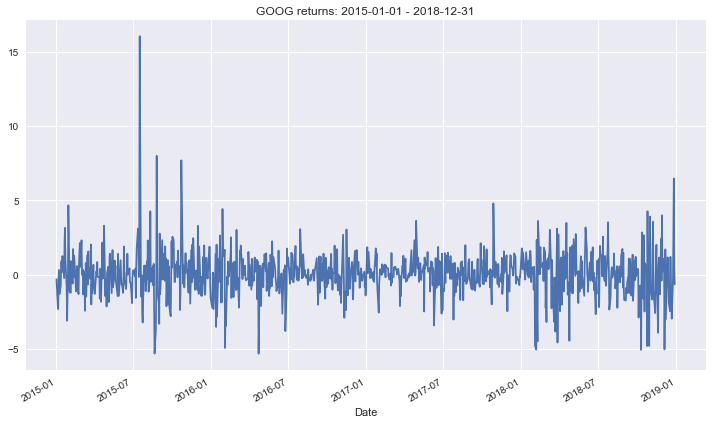

In [19]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'
print(f'Average return: {round(returns.mean(), 2)}%')
returns.plot(title=f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}');

plt.tight_layout()

5. Specify the ARCH model:

In [34]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=3, o=3, q=3)

6. Estimate the model and print the summary:

In [35]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -1769.85
Distribution:                  Normal   AIC:                           3547.69
Method:            Maximum Likelihood   BIC:                           3567.34
                                        No. Observations:                 1005
Date:                Thu, Nov 26 2020   Df Residuals:                     1001
Time:                        20:38:21   Df Model:                            4
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.1759      0.161      7.307  2.725e-13    [  

7. Plot the residuals and the conditional volatility:

The standardized residuals were computed by dividing the residuals by the conditional volatility. By passing annualize='D' to the plot method, we indicated that we wanted to annualize the conditional volatility series from daily data.

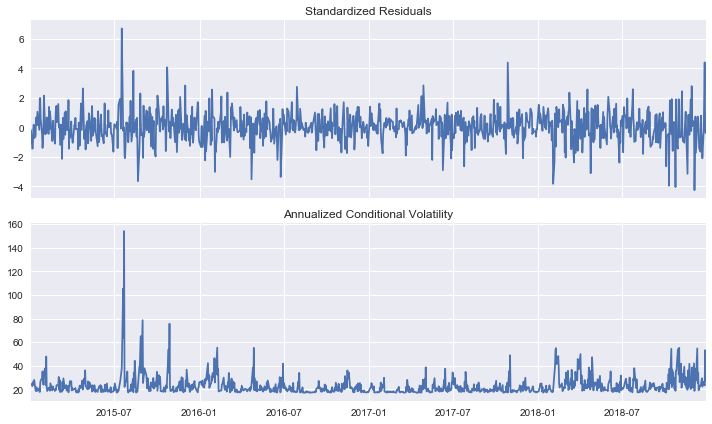

In [33]:
 .plot(annualize='D')

plt.tight_layout()

## Explaining stock returns' volatility with GARCH models

### How to do it...

1. Specify the GARCH model:

 - p: The number of lag variances
 - q: The number of lag residual errors from a mean process

In [37]:
model = arch_model(returns, mean='Zero', vol='GARCH', 
                   p=1, o=1, q=1)

2. Estimate the model and print the summary:

In [38]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())
model_fitted.

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1764.04
Distribution:                  Normal   AIC:                           3536.08
Method:            Maximum Likelihood   BIC:                           3555.73
                                        No. Observations:                 1005
Date:                Thu, Nov 26 2020   Df Residuals:                     1001
Time:                        20:38:38   Df Model:                            4
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1888      0.131      1.443      0.149 [-6.76

3. Plot the residuals and the conditional volatility:

In the plots shown below, we can observe the effect of including the extra component (lagged conditional volatility) into the model specification.

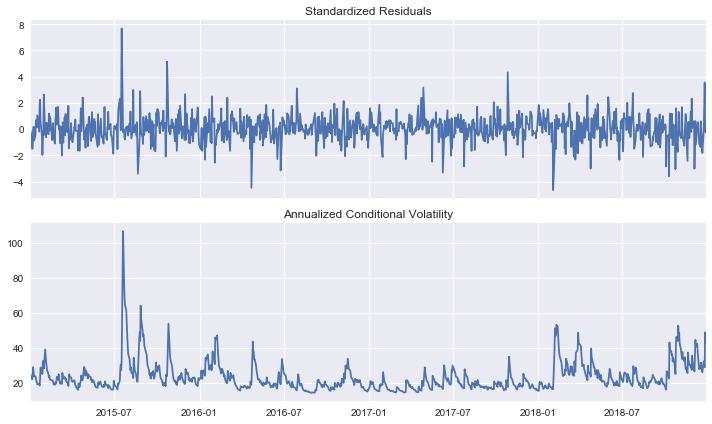

In [39]:
model_fitted.plot(annualize='D')

plt.tight_layout()

When using ARCH, the conditional volatility series exhibits many spikes, and then immediately returns to the low level. In the case of GARCH, as the model also includes lagged conditional volatility, it takes more time to return to the level observed before the spike.

## Other models

- GJR-GARCH: A variant of the GARCH model that takes into account the asymmetry of the returns (negative returns tend to have a stronger impact on volatility than positive ones)
- EGARCH: Exponential GARCH
- TGARCH: Threshold GARCH
- FIGARCH: Fractionally integrated GARCH, used with non-stationary data
- GARCH-MIDAS: In this class of models, volatility is decomposed into a short-term GARCH component and a long-term component driven by an additional explanatory variable
- Multivariate GARCH models, such as CCC-/DCC-GARCH

The arch library provides most of the models and distributions mentioned, and also allows for the use of your own volatility models/distributions of errors, as long as they fit into a predefined format. For more information on this, please refer to the excellent documentation at 
https://arch.readthedocs.io/en/latest/index.html.

## Implementing CCC-GARCH model for multivariate volatility forecasting

### How to do it...

1. Import the libraries:

In [55]:
import pandas as pd
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [56]:
RISKY_ASSETS = ['GOOG', 'MSFT', 'AAPL']
N = len(RISKY_ASSETS)
START_DATE = '2015-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [57]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True)

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 1006 rows of data.


4. Calculate daily returns:

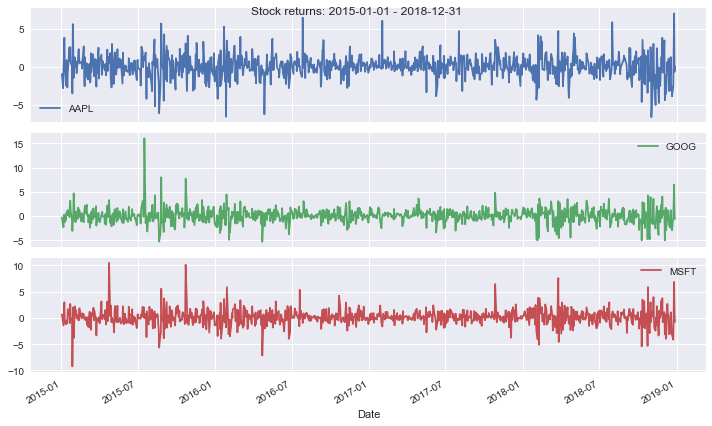

In [58]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.plot(subplots=True, 
             title=f'Stock returns: {START_DATE} - {END_DATE}')

plt.tight_layout()

5. Define lists for storing objects:

In [59]:
coeffs = []
cond_vol = []
std_resids = []
models = []

6. Estimate the univariate GARCH models:

In [60]:
for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean='Constant', 
                       vol='GARCH', p=1, o=0, q=1).fit(update_freq=0, 
                                                       disp='off');
    # store results in the lists 
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.resid / model.conditional_volatility)
    models.append(model)

- It avoids the problem of guaranteeing positive definiteness of t by splitting it into variances and correlations.
- The conditional correlations between error terms are constant over time.
- Individual conditional variances follow a univariate GARCH(1,1) model.

7. Store the results in DataFrames:

In [61]:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = pd.DataFrame(cond_vol).transpose() \
                                    .set_axis(returns.columns, 
                                              axis='columns', 
                                              inplace=False)
std_resids_df = pd.DataFrame(std_resids).transpose() \
                                        .set_axis(returns.columns, 
                                                  axis='columns', 
                                                  inplace=False)

In [62]:
coeffs_df

,mu,omega,alpha[1],beta[1]
AAPL,0.123494,0.221226,0.125915,0.784530
GOOG,0.080485,0.193127,0.187875,0.747864
MSFT,0.119525,0.384324,0.251944,0.625823


8. Calculate the constant conditional correlation matrix (R):

we calculated the constant conditional correlation matrix (R) as the unconditional correlation matrix of zt:

In [65]:
std_resids_df

,AAPL,GOOG,MSFT
Date,,,
2015-01-02,-0.554289,-0.252626,0.275106
2015-01-05,-1.614829,-1.556269,-0.605807
2015-01-06,-0.057674,-1.510358,-1.004388
2015-01-07,0.704795,-0.141674,0.716294
2015-01-08,2.143597,0.146545,1.847352
...,...,...,...
2018-12-21,-1.937797,-1.904626,-1.789791
2018-12-24,-1.144166,-0.214208,-1.846474
2018-12-26,2.936622,3.637495,2.314022


In [67]:
R = std_resids_df.transpose() \
                 .dot(std_resids_df) \
                 .div(len(std_resids_df))
R

,AAPL,GOOG,MSFT
AAPL,1.001341,0.498643,0.515955
GOOG,0.498643,1.000092,0.657395
MSFT,0.515955,0.657395,0.999270


9. Calculate the 1-step ahead forecast of the conditional covariance matrix :

- We created a matrix Dt+1 of zeros, using np.zeros.
- We stored the one-step-ahead forecasts of conditional variances from univariate GARCH models in a list called diag. 
- Using np.fill_diagonal, we placed the elements of the list called diag on the diagonal of the matrix  Dt+1.
- Following equation 3, we obtained the one-step-ahead forecast using matrix multiplication (np.matmul).

In [90]:
# define objects
diag = []
D = np.zeros((N, N))

# populate the list with conditional variances
for model in models:
    print (model.forecast(horizon=1).variance.values[-1][0])
    diag.append(model.forecast(horizon=1).variance.values[-1][0])
# take the square root to obtain volatility from variance
print (diag)
diag = np.sqrt(np.array(diag))
# fill the diagonal of D with values from diag
print (D)
print (np.fill_diagonal(D, diag))

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)
np.matmul(np.matmul(D, R.values), D)

6.9805268825150355
6.157528365650707
7.525035155587646
[6.9805268825150355, 6.157528365650707, 7.525035155587646]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
None


array([[6.98989074, 3.26916827, 3.73946848],
       [3.26916827, 6.15809531, 4.47490864],
       [3.73946848, 4.47490864, 7.51953918]])

In [88]:
(D @ R.values)

array([[2.64561282, 1.31744977, 1.36318755],
       [1.23735174, 2.48166523, 1.63128524],
       [1.41535628, 1.8033539 , 2.74117625]])

In [73]:
H

array([[6.98989074, 3.26916827, 3.73946848],
       [3.26916827, 6.15809531, 4.47490864],
       [3.73946848, 4.47490864, 7.51953918]])

## Forecasting the conditional covariance matrix using DCC-GARCH

Estimate the univariate GARCH models for conditional volatility

Estimate the DCC model for conditional correlations

### How to do it...

1. Import the libraries:

In [24]:
# !pip install mgarch

# https://github.com/srivastavaprashant/mgarch

In [92]:
import mgarch

In [93]:
import scipy
scipy.__version__

'1.4.1'

In [94]:
!pip install --user scipy==1.4.1 --force-reinstall

     |████████████████████████████████| 28.4 MB 422 kB/s eta 0:00:01    |██████▍                         | 5.7 MB 404 kB/s eta 0:00:57
     |████████████████████████████████| 15.3 MB 1.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [95]:
returns.head()

,AAPL,GOOG,MSFT
Date,,,
2015-01-02,-0.951252,-0.302049,0.667391
2015-01-05,-2.817168,-2.084573,-0.919560
2015-01-06,0.009425,-2.317705,-1.467750
2015-01-07,1.402210,-0.171326,1.270522
2015-01-08,3.842227,0.315308,2.941813


2. Estimate the model:

In [32]:
# For Multivariate normal Distribution
# rt = (t, n) numpy matrix with t days of observation and n number of assets
import mgarch
vol = mgarch.mgarch()
vol.fit(returns)
ndays = 10 # volatility of nth day
cov_nextday = vol.predict(ndays)

3. Calculate the 10-step ahead forecasts:

In [33]:
cov_nextday

{'dist': 'norm',
 'cov': array([[13.36924258,  2.15760028,  2.96778223],
        [ 2.15760028, 12.61706543,  4.17276073],
        [ 2.96778223,  4.17276073, 17.63665352]])}

In [34]:
# For Multivariate Student-t Distribution
# rt = (t, n) numpy matrix with t days of observation and n number of assets
import mgarch
dist = 't'
vol = mgarch.mgarch(dist)
vol.fit(returns)
ndays = 10 # volatility of nth day
cov_nextday = vol.predict(ndays)

In [30]:
cov_nextday

{'dist': 't',
 'dof': 3.999999996461609,
 'cov': array([[13.36924258,  2.18101958,  2.98707904],
        [ 2.18101958, 12.61706543,  4.19642343],
        [ 2.98707904,  4.19642343, 17.63665352]])}

In [84]:
np.matmul??